## Xavier and Constant Variance Initialisation CIFAR Classification comparison

This notebook compares Constant Variance initialisation to Xavier initialisation when classifying the CIFAR10 dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets

from sklearn import linear_model

import torchvision
from torchvision.transforms import Compose

import torch
from torch import nn

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

C:\Users\rmen2\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def XavierInitialisation(network):
    """ Perform Xavier Initialisation on a Neural Network """
    for p in network.modules():
        if p.__class__.__name__ == "Linear" or p.__class__.__name__ == "Conv2d":
            with torch.no_grad():
                nn.init.xavier_uniform_(p.weight)
                p.bias.zero_()

def XavierInitialisationNormal(network):
    """ Perform Xavier Initialisation on a Neural Network """
    for p in network.modules():
        if p.__class__.__name__ == "Linear" or p.__class__.__name__ == "Conv2d":
            with torch.no_grad():
                nn.init.xavier_normal_(p.weight)
                p.bias.zero_()

# All the coefficients for maintaining a constant variance propagation
normalising_coeff_dict = {
    #nn.Sigmoid: 1.92,
    nn.Tanh: 1.58,
    nn.ReLU: 1.41,
    #nn.Softsign: 2.317374,
    #nn.ELU: 1.242043
}

normalising_coeff_arr = normalising_coeff_dict.values()

activation_functions = [
    nn.ReLU,
    nn.Tanh,
    nn.Sigmoid,
    nn.SELU,
    nn.GELU
]

def ConstVarInitialisation(network, normalising_coefficient=None, normal=False):
    """ Perform Constant Variance Initialisation on a Neural Network """
    net_modules = list(network.modules())
    for i, p in enumerate(network.modules()):
        if p.__class__.__name__ == "Linear" and net_modules[
            i - 1].__class__ in activation_functions or p.__class__.__name__ == "Conv2d" and normalising_coefficient is not None:
            with torch.no_grad():
                receptive_field_size = 1
                if p.weight.dim() > 2:
                    for s in p.weight.shape[2:]:
                        receptive_field_size *= s
                if normalising_coefficient is None:
                    # Get what the coefficient should be by looking at the applied activation before this layer
                    normalising_coefficient = normalising_coeff_dict[net_modules[i - 1].__class__]
                if normal:
                  p.weight.normal_(0, normalising_coefficient / np.sqrt(p.weight.shape[1]*receptive_field_size))
                else:
                  p.weight.uniform_(
                      -normalising_coefficient / np.sqrt(p.weight.shape[1]*receptive_field_size), 
                      normalising_coefficient / np.sqrt(p.weight.shape[1]*receptive_field_size)
                      )
                p.bias.zero_()


def test_backpropagation(neural_network, data_loader, loss_fn):
    """ Get the backpropagation distributions from running a number of inputs to the network """
    handles = []
    layerID = 0
    backpropagation_values = {}
    # Set hooks
    def set_backward_hooks(name):
        def hook(model, input, output):
            backpropagation_values[name].append(output[0].detach())
        return hook

    # Initialise hook storage holders
    for m in neural_network.modules():
        if m.__class__.__name__ == "Linear" or m.__class__.__name__ == "Conv2d":
            handles.append(m.register_full_backward_hook(set_backward_hooks(layerID)))
            backpropagation_values[layerID] = []
            layerID+=1

    # Run a few inputs through the network and measure backpropagation with hooks
    for batch, (X, y) in enumerate(data_loader):
        pred = neural_network(X)
        loss = loss_fn(pred, y)

        loss.backward()
        if batch > 20:
            break

    # Remove hooks
    for h in handles:
        h.remove()

    return backpropagation_values

def test_backpropagation_scaled(neural_network, data_loader, loss_fn):
    """ Get the backpropagation distributions from running a number of inputs to the network """
    handles = []
    layerID = 0
    backpropagation_values = {}
    # Set hooks
    def set_backward_hooks(name):
        def hook(model, input, output):
            backpropagation_values[name].append(output[0].detach())
        return hook

    # Initialise hook storage holders
    for m in neural_network.modules():
        if m.__class__.__name__ == "Linear":
            handles.append(m.register_full_backward_hook(set_backward_hooks(layerID)))
            backpropagation_values[layerID] = []
            layerID+=1

    # Run a few inputs through the network and measure backpropagation with hooks
    for batch, (X, y) in enumerate(data_loader):
        # Compute how to scale the backpropagation to ensure it is constant variance the backpropagation which ensures
        pred = neural_network(X)
        loss = loss_fn(pred, y)

        loss.backward()

        # Get the variance of the gradient of the 2nd last module (layer before output layer), then mimic that over all layers
        print(neural_network.modules())
        propagated_var = np.var(neural_network.modules()[-2].grad)
        backpropagation_values.append(neural_network.modules()[0])
        for i, m in enumerate(neural_network.modules()[1:]):
            m.grad *= propagated_var/m.grad #/neural_network.modules()[i-1]
            backpropagation_values.append(m.grad)

        if batch > 20:
            break

    # Remove hooks
    for h in handles:
        h.remove()

    return backpropagation_values

In [3]:
def test_forward_propagation(neural_network, data, loss_fn, device, transform=torchvision.transforms.Compose([]), name="Tanh"):
    # Handles for the layer hooks
    handles = []

    # Register a forward hook to get the value of each layer
    layer_intermediate_values = {}
    def set_forward_hooks(name):
        def hook(model, input, output):
            layer_intermediate_values[name] = output.detach()
        return hook

    layerID = 0
    for m in neural_network.modules():
        if m.__class__.__name__ == "Linear" or m.__class__.__name__ == "Conv2d" or m.__class__.__name__ ==  name:
            handles.append(m.register_forward_hook(set_forward_hooks(layerID)))
            layerID += 1

    # Need to run network to get intermediate values
    _out = neural_network(transform(torch.stack([data[d][0] for d in range(64)]).to(device))) #torch.normal(0, 1, size=(100_000, 28*28)))

    # Remove all handles
    for h in handles:
        h.remove()

    del handles
    del _out

    # Return the intermediate values in the layers
    return layer_intermediate_values

In [4]:
class Tanh8(nn.Module):
    """ Tanh8 activation function = Tanh(x*8)/8"""
    def __init__(self, inplace: bool = False):
        super(Tanh8, self).__init__()
        self.inplace = inplace
        self.tanh = nn.Tanh()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.tanh(input/8)*8

    def extra_repr(self) -> str:
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str


In [5]:
# The CIFAR10 dataset
cifar10_dataset_augmented = datasets.CIFAR10(
    root="./datasets",
    train=True,
    download=True,
    transform=Compose([
        ToTensor(),
        lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=False)(x)
    ])
)

# The dataset applied through the training transform
train_transform = transform=Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    #lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=True)(x)
])

# The dataset applied through the validation transform
validation_transform = transform =Compose([
    #lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=True)(x)
])

# Split the dataset into train and validation
cifar10_dataset_train, cifar10_dataset_validation = torch.utils.data.random_split(cifar10_dataset_augmented, [45000, 5000])

# Create dataloaders
cifar10_dataset_loader_train = DataLoader(cifar10_dataset_train, batch_size=64, shuffle=True)
cifar10_dataset_loader_validation = DataLoader(cifar10_dataset_validation, batch_size=64, shuffle=False)

Files already downloaded and verified


In [6]:
# The CIFAR10 dataset, where a half std is applied to the input (instead of standard normalisation)

# The dataset applied through the training transform
train_transform_half_std = transform =Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=True)(x) * 0.5
])

# The dataset applied through the validation transform
validation_transform_half_std = transform =Compose([
    lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=True)(x) * 0.5
])

In [7]:

class NNCIFAR10(nn.Module):
    """ 
    Neural network for use with the CIFAR10 dataset.
    A 19 Layer Network almost identical to VGG-19, except padding was added to allow the input to reach the output.
    """
    def __init__(self, activation_function):
        super(NNCIFAR10, self).__init__()
        self.module_stack = nn.Sequential(
            # Input = layer 0
            nn.Conv2d(3, 64, (3, 3), padding=2), # 1
            activation_function(),
            nn.Conv2d(64, 64, (3, 3), padding=2), # 2
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, (3, 3), padding=2), # 3
            activation_function(),
            nn.Conv2d(128, 128, (3, 3), padding=2), # 4
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(128, 256, (3, 3), padding=2), # 5
            activation_function(),
            nn.Conv2d(256, 256, (3, 3), padding=2), # 6
            activation_function(),
            nn.Conv2d(256, 256, (3, 3), padding=2), # 7
            activation_function(),
            nn.Conv2d(256, 256, (3, 3), padding=2), # 8
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(256, 512, (3, 3), padding=2), # 9
            activation_function(),
            nn.Conv2d(512, 512, (3, 3), padding=2), # 10
            activation_function(),
            nn.Conv2d(512, 512, (3, 3), padding=2), # 11
            activation_function(),
            nn.Conv2d(512, 512, (3, 3), padding=2), # 12
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(512, 512, (3, 3), padding=0), # 13
            activation_function(),
            nn.Conv2d(512, 512, (3, 3), padding=0), # 14
            activation_function(),
            nn.MaxPool2d((2, 2)),

            nn.Flatten(),

            nn.Linear(2048, 2048), # 15
            activation_function(),
            nn.Dropout(0.25),
            nn.Linear(2048, 2048), # 16
            activation_function(),
            nn.Dropout(0.4),
            nn.Linear(2048, 1024), # 17
            activation_function(),
            nn.Dropout(0.25),
            nn.Linear(1024, 10), # 18
        )

    def forward(self, x):
        return self.module_stack(x)

In [10]:
lr = linear_model.LinearRegression()
loss_fn = nn.CrossEntropyLoss()
epochs = 5
num_epochs = 0
batch_count = 0
print_every = 100
store_loss_every = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [11]:
def training_loop(network, 
                  optimiser, 
                  dataset_loader_train, 
                  dataset_loader_validation, 
                  loss_arr, acc_validation, 
                  epochs=40,
                  train_transform=train_transform, 
                  validation_transform=validation_transform):
  """ Train a network on the CIFAR10 dataset """
  lr = linear_model.LinearRegression()
  num_epochs = 0
  batch_count = 0

  for i in range(epochs):
      num_epochs += 1

      print()
      print("=================================")
      print("Epoch: " + str(num_epochs))
      print("=================================")
      for batch, (X, y) in enumerate(dataset_loader_train):
          loss =  loss_fn(network(train_transform(X).to(device)), y.to(device)) #, inplace=True
          optimiser.zero_grad()
          loss.backward()
          optimiser.step()

          # Print
          if batch % print_every == 0:
              cur_acc_val = get_accuracy(network, dataset_loader_validation, device, validation_transform)
              acc_validation.append([cur_acc_val])
              if batch_count > 25:
                acc_grad = lr.fit(np.arange(25).reshape(-1, 1), acc_validation[-25:]).coef_[0]
                print("\rloss: " + str(loss.item()) + " | acc: " + str(cur_acc_val) + " | acc_grad: " + str(acc_grad) + "                        ", end="")
                if acc_grad < 0.00001:
                  # Validation accuracy has stopped improving, decrease learning rate
                  for g in optimiser.param_groups:
                    g['lr'] = g['lr'] * 0.1
                    print()
                    print("Decreased Learning Rate by a factor of 10")
                    batch_count = 10
              else:
                batch_count += 1
                print("\rloss: " + str(loss.item()) + " acc: " + str(cur_acc_val) + "                        ", end="")
          if batch % store_loss_every == 0:
              loss_arr.append(loss.item())

def run_test(initialisation, 
             activation = nn.Tanh, 
             dataset_loader_train = cifar10_dataset_loader_train, 
             dataset_loader_validation = cifar10_dataset_loader_validation,
             train_transform=train_transform,
             validation_transform=validation_transform):
  """ Run an initialisation test on the CIFAR dataset """
  network = NNCIFAR10(activation).to(device)
  initialisation(network)
  optimiser = torch.optim.SGD(network.parameters(), lr=0.001, momentum=0.9,
                            weight_decay=1e-5)
  loss_fn = nn.CrossEntropyLoss()

  loss_arr = []
  acc_validation = []

  training_loop(
      network, 
      optimiser, 
      dataset_loader_train, 
      dataset_loader_validation,
      loss_arr, 
      acc_validation,
      40)
  
  return loss_arr, acc_validation, network, optimiser

cur_test = 1

def get_accuracy(model, dataloader, device, transform):
  """ Determine the top-1 accuracy of the model using the data in the `dataloader` """
  model.eval()
  with torch.no_grad():
    acc_total = 0
    acc_len = 0
    for X,y in dataloader:
      acc_total += (torch.argmax(model(transform(X).to(device)), dim=1) == y.to(device)).int().sum()
      acc_len += len(y)
    final_acc = acc_total/acc_len
  model.train()
  return final_acc.item()

def save_arr(name, arr):
  with open("/content/drive/MyDrive/Datasets/CIFARDataset/" + name, "w+") as f:
    f.write(",".join([str(i) for i in arr]))
    
def save_net(name, network):
  torch.save(network, "/content/drive/MyDrive/Datasets/CIFARDataset/" + name)

def save_arr_local(name, arr, itera=0):
  with open("./XavierCIFAR_test/" + str(itera) + "/" + name, "w+") as f:
    f.write(",".join([str(i) for i in arr]))
    
def save_net_local(name, network, itera=0):
  torch.save(network, "./XavierCIFAR_test/" + str(itera) + "/" + name)

def load_arr_local(name, arr):
  with open("./CIFAR_test/" + str(cur_test) + "/" + name, "w+") as f:
    return [float(i) for i in f.read().split(",")]
    
def load_net_local(name, network):
  return torch.load(network, "./CIFAR_test/" + str(cur_test) + "/" + name)


In [12]:
for i in range(0, 5):
    xavier_loss_arr, xavier_acc_validation, xavier_model, xavier_optimiser = run_test(lambda x: XavierInitialisationNormal(x))
    xavier_model.to("cpu")

    save_arr_local("xavier_normal_loss_arr", xavier_loss_arr, i)
    save_arr_local("xavier_normal_acc_validation", xavier_acc_validation, i)

    save_net_local("xavier_normal_model", xavier_model, i)
    save_net_local("xavier_normal_optimiser", xavier_optimiser, i)

    del xavier_loss_arr
    del xavier_acc_validation
    del xavier_model
    del xavier_optimiser

    print()


Epoch: 1
loss: 1.2554160356521606 acc: 0.5180000066757202                         
Epoch: 2
loss: 1.0668476819992065 acc: 0.6075999736785889                        
Epoch: 3
loss: 0.7132335305213928 acc: 0.6717999577522278                        
Epoch: 4
loss: 0.8975563049316406 | acc: 0.7039999961853027 | acc_grad: [0.00791308]                        
Epoch: 5
loss: 0.7919312119483948 | acc: 0.7364000082015991 | acc_grad: [0.00534462]                        
Epoch: 6
loss: 0.6088032722473145 | acc: 0.7608000040054321 | acc_grad: [0.00400385]                         
Epoch: 7
loss: 0.4673723578453064 | acc: 0.7665999531745911 | acc_grad: [0.00222323]                         
Epoch: 8
loss: 0.4405612051486969 | acc: 0.771399974822998 | acc_grad: [0.00136969]                          
Epoch: 9
loss: 0.6988278031349182 | acc: 0.7895999550819397 | acc_grad: [0.00094508]                         
Epoch: 10
loss: 0.2787201404571533 | acc: 0.776199996471405 | acc_grad: [0.00082]             

In [13]:
#tensor(2.7584
for i in range(0, 5):
    const_var_uniform_loss_arr, const_var_uniform_acc_validation, const_var_uniform_model, const_var_uniform_optimiser = run_test(lambda x: ConstVarInitialisation(x, 2.7584))
    const_var_uniform_model.to("cpu")

    save_arr_local("const_var_uniform_loss_arr", const_var_uniform_loss_arr, i)
    save_arr_local("const_var_uniform_acc_validation", const_var_uniform_acc_validation, i)

    save_net_local("const_var_uniform_model", const_var_uniform_model, i)
    save_net_local("const_var_uniform_optimiser", const_var_uniform_optimiser, i)

    del const_var_uniform_loss_arr
    del const_var_uniform_acc_validation
    del const_var_uniform_model
    del const_var_uniform_optimiser
    print()


Epoch: 1
loss: 1.6085479259490967 acc: 0.4189999997615814                         
Epoch: 2
loss: 1.5857218503952026 acc: 0.4673999845981598                         
Epoch: 3
loss: 1.2333064079284668 acc: 0.5347999930381775                         
Epoch: 4
loss: 1.0480815172195435 | acc: 0.5839999914169312 | acc_grad: [0.00737954]                        
Epoch: 5
loss: 0.7663748264312744 | acc: 0.6123999953269958 | acc_grad: [0.00528923]                        
Epoch: 6
loss: 0.9220676422119141 | acc: 0.6419999599456787 | acc_grad: [0.00420831]                        
Epoch: 7
loss: 0.7668586373329163 | acc: 0.6606000065803528 | acc_grad: [0.00307446]                        
Epoch: 8
loss: 0.8947654366493225 | acc: 0.6592000126838684 | acc_grad: [0.00210554]                        
Epoch: 9
loss: 1.1216049194335938 | acc: 0.6832000017166138 | acc_grad: [0.00195031]                        
Epoch: 10
loss: 0.49223795533180237 | acc: 0.6751999855041504 | acc_grad: [0.00106323]          

In [14]:

for i in range(0, 5):
    const_var_normal_loss_arr, const_var_normal_acc_validation, const_var_normal_model, const_var_normal_optimiser = run_test(lambda x: ConstVarInitialisation(x, 1.5925, normal=True))
    const_var_normal_model.to("cpu")

    save_arr_local("const_var_normal_loss_arr", const_var_normal_loss_arr, i)
    save_arr_local("const_var_normal_acc_validation", const_var_normal_acc_validation, i)

    save_net_local("const_var_normal_model", const_var_normal_model, i)
    save_net_local("const_var_normal_optimiser", const_var_normal_optimiser, i)

    del const_var_normal_loss_arr
    del const_var_normal_acc_validation
    del const_var_normal_model
    del const_var_normal_optimiser

    print()


Epoch: 1
loss: 1.549627423286438 acc: 0.43619999289512634                         
Epoch: 2
loss: 1.4695913791656494 acc: 0.4887999892234802                         
Epoch: 3
loss: 1.3153754472732544 acc: 0.5661999583244324                        
Epoch: 4
loss: 1.0615620613098145 | acc: 0.6085999608039856 | acc_grad: [0.00734615]                        
Epoch: 5
loss: 1.1058627367019653 | acc: 0.6111999750137329 | acc_grad: [0.00503662]                        
Epoch: 6
loss: 1.0199024677276611 | acc: 0.6186000108718872 | acc_grad: [0.00338815]                        
Epoch: 7
loss: 0.7379350662231445 | acc: 0.644599974155426 | acc_grad: [0.00255662]                         
Epoch: 8
loss: 0.8931374549865723 | acc: 0.6620000004768372 | acc_grad: [0.00181785]                        
Epoch: 9
loss: 0.6630035042762756 | acc: 0.6815999746322632 | acc_grad: [0.001474]                          
Epoch: 10
loss: 0.659587562084198 | acc: 0.6886000037193298 | acc_grad: [0.001106]               

In [15]:
for i in range(0, 5):
    const_var_tanh8_loss_arr, const_var_tanh8_acc_validation, const_var_tanh8_model, const_var_tanh8_optimiser = run_test(lambda x: ConstVarInitialisation(x, 1.0153, True), activation=Tanh8)
    const_var_tanh8_model.to("cpu")

    save_arr_local("const_var_tanh8_loss_arr", const_var_tanh8_loss_arr, i)
    save_arr_local("const_var_tanh8_acc_validation", const_var_tanh8_acc_validation, i)


    save_net_local("const_var_tanh8_model", const_var_tanh8_model, i)
    save_net_local("const_var_tanh8_optimiser", const_var_tanh8_optimiser, i)

    del const_var_tanh8_loss_arr
    del const_var_tanh8_acc_validation
    del const_var_tanh8_model
    del const_var_tanh8_optimiser

    print()


Epoch: 1
loss: 1.3336421251296997 acc: 0.495199978351593                          
Epoch: 2
loss: 1.0770175457000732 acc: 0.6003999710083008                        
Epoch: 3
loss: 0.928011417388916 acc: 0.6665999889373779                         
Epoch: 4
loss: 1.0777428150177002 | acc: 0.6877999901771545 | acc_grad: [0.00797231]                        
Epoch: 5
loss: 0.8305431008338928 | acc: 0.7202000021934509 | acc_grad: [0.00453108]                        
Epoch: 6
loss: 0.6867261528968811 | acc: 0.7311999797821045 | acc_grad: [0.00304415]                         
Epoch: 7
loss: 0.5127230882644653 | acc: 0.7487999796867371 | acc_grad: [0.00232908]                        
Epoch: 8
loss: 0.6041110754013062 | acc: 0.7567999958992004 | acc_grad: [0.00186277]                        
Epoch: 9
loss: 0.38946276903152466 | acc: 0.746999979019165 | acc_grad: [0.00112554]                         
Epoch: 10
loss: 0.517859697341919 | acc: 0.7683999538421631 | acc_grad: [0.00062585]            

In [16]:
for i in range(0, 5):
    const_var_half_std_loss_arr, const_var_half_std_acc_validation, const_var_half_std_model, const_var_half_std_optimiser = run_test(
        lambda x: ConstVarInitialisation(x, 1.2003, True),
        train_transform = train_transform_half_std,
        validation_transform = validation_transform_half_std
    )
    const_var_half_std_model.to("cpu")

    save_arr_local("const_var_half_std_loss_arr", const_var_half_std_loss_arr, i)
    save_arr_local("const_var_half_std_acc_validation", const_var_half_std_acc_validation, i)

    save_net_local("const_var_half_std_model", const_var_half_std_model, i)
    save_net_local("const_var_half_std_optimiser", const_var_half_std_optimiser, i)

    del const_var_half_std_loss_arr
    del const_var_half_std_acc_validation
    del const_var_half_std_model
    del const_var_half_std_optimiser

    print()


Epoch: 1
loss: 1.5937267541885376 acc: 0.42080000042915344                        
Epoch: 2
loss: 1.1442828178405762 acc: 0.5234000086784363                        
Epoch: 3
loss: 1.120483636856079 acc: 0.6157999634742737                         
Epoch: 4
loss: 0.8948419094085693 | acc: 0.6471999883651733 | acc_grad: [0.00988385]                        
Epoch: 5
loss: 0.8398691415786743 | acc: 0.6881999969482422 | acc_grad: [0.00662538]                        
Epoch: 6
loss: 0.6689375638961792 | acc: 0.6943999528884888 | acc_grad: [0.00388385]                        
Epoch: 7
loss: 0.8649352192878723 | acc: 0.6965999603271484 | acc_grad: [0.00256846]                         
Epoch: 8
loss: 0.5437970757484436 | acc: 0.7379999756813049 | acc_grad: [0.00189631]                        
Epoch: 9
loss: 0.5302820801734924 | acc: 0.7263999581336975 | acc_grad: [0.00114154]                         
Epoch: 10
loss: 0.48502135276794434 | acc: 0.7513999938964844 | acc_grad: [0.00143939]          

In [17]:
for i in range(0, 5):
    xavier_loss_arr, xavier_acc_validation, xavier_model, xavier_optimiser = run_test(lambda x: XavierInitialisation(x))
    xavier_model.to("cpu")

    save_arr_local("xavier_uniform_loss_arr", xavier_loss_arr, i)
    save_arr_local("xavier_uniform_acc_validation", xavier_acc_validation, i)

    save_net_local("xavier_uniform_model", xavier_model, i)
    save_net_local("xavier_uniform_optimiser", xavier_optimiser, i)

    del xavier_loss_arr
    del xavier_acc_validation
    del xavier_model
    del xavier_optimiser

    print()


Epoch: 1
loss: 1.5234757661819458 acc: 0.5151999592781067                         
Epoch: 2
loss: 1.0421749353408813 acc: 0.6155999898910522                        
Epoch: 3
loss: 0.6549515128135681 acc: 0.6887999773025513                        
Epoch: 4
loss: 0.9590591788291931 | acc: 0.7148000001907349 | acc_grad: [0.00852569]                        
Epoch: 5
loss: 0.9333259463310242 | acc: 0.7393999695777893 | acc_grad: [0.00487231]                        
Epoch: 6
loss: 0.4379499852657318 | acc: 0.7543999552726746 | acc_grad: [0.00281215]                        
Epoch: 7
loss: 0.5812497138977051 | acc: 0.7608000040054321 | acc_grad: [0.00256831]                         
Epoch: 8
loss: 0.47965750098228455 | acc: 0.7784000039100647 | acc_grad: [0.00175508]                        
Epoch: 9
loss: 0.4311113953590393 | acc: 0.7815999984741211 | acc_grad: [0.00110862]                         
Epoch: 10
loss: 0.24544715881347656 | acc: 0.7789999842643738 | acc_grad: [0.00080615]         

In [ ]:
const_var_tanh8_uniform_loss_arr, const_var_tanh8_uniform_acc_validation, const_var_tanh8_uniform_model, const_var_tanh8_uniform_optimiser = run_test(lambda x: ConstVarInitialisation(x, 1.59), activation=Tanh8)
const_var_tanh8_uniform_model.to("cpu")

print()

In [ ]:
save_arr_local("const_var_tanh8_uniform_loss_arr", const_var_tanh8_uniform_loss_arr)
save_arr_local("const_var_tanh8_uniform_acc_validation", const_var_tanh8_uniform_acc_validation)

save_net_local("const_var_tanh8_uniform_model", const_var_tanh8_uniform_model)
save_net_local("const_var_tanh8_uniform_optimiser", const_var_tanh8_uniform_optimiser)

In [ ]:
const_var_half_std_uniform_loss_arr, const_var_half_std_uniform_acc_validation, const_var_half_std_uniform_model, const_var_half_std_uniform_optimiser = run_test(
    lambda x: ConstVarInitialisation(x, 1.59), 
    train_transform = train_transform_half_std,
    validation_transform = validation_transform_half_std
)
const_var_half_std_uniform_model.to("cpu")

print()

In [ ]:
save_arr_local("const_var_half_std_uniform_loss_arr", const_var_half_std_uniform_loss_arr)
save_arr_local("const_var_half_std_uniform_acc_validation", const_var_half_std_uniform_acc_validation)

save_net_local("const_var_half_std_uniform_model", const_var_half_std_uniform_model)
save_net_local("const_var_half_std_uniform_optimiser", const_var_half_std_uniform_optimiser)

In [8]:

xavier_loss_loaded = []

const_var_loss_loaded = []
const_var_loss_tanh8_loaded = []
const_var_loss_half_std_loaded = []
const_var_loss_uniform_loaded = []


xavier_acc_validation_loaded = []

const_var_acc_validation_loaded = []
const_var_acc_validation_tanh8_loaded = []
const_var_acc_validation_half_std_loaded = []
const_var_acc_validation_uniform_loaded = []

for i in range(0, 5):

    def loadOpenFile(filename):
        return open("XavierCIFAR_test/" + str(i) + "/" + filename, "r")

    # Load data
    with loadOpenFile("xavier_normal_loss_arr") as f:
        xavier_loss_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("xavier_normal_acc_validation") as f:
        xavier_acc_validation_loaded.append([float(i[1:-1]) for i in f.read().split(",")])

    #######################

    with loadOpenFile("const_var_normal_loss_arr") as f:
        const_var_loss_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("const_var_normal_acc_validation") as f:
        const_var_acc_validation_loaded.append([float(i[1:-1]) for i in f.read().split(",")])

    #######################

    with loadOpenFile("const_var_tanh8_loss_arr") as f:
        const_var_loss_tanh8_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("const_var_tanh8_acc_validation") as f:
        const_var_acc_validation_tanh8_loaded.append([float(i[1:-1]) for i in f.read().split(",")])

    #######################

    with loadOpenFile("const_var_half_std_loss_arr") as f:
        const_var_loss_half_std_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("const_var_half_std_acc_validation") as f:
        const_var_acc_validation_half_std_loaded.append([float(i[1:-1]) for i in f.read().split(",")])

    #######################

    with loadOpenFile("const_var_uniform_loss_arr") as f:
        const_var_loss_uniform_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("const_var_uniform_acc_validation") as f:
        const_var_acc_validation_uniform_loaded.append([float(i[1:-1]) for i in f.read().split(",")])


In [9]:

def window_data(data, moving_window_size=40):
    return np.convolve(data, np.ones(moving_window_size), 'valid') / moving_window_size

In [14]:
xavier_loss_loaded[1]

[2.3403432369232178,
 2.2932939529418945,
 2.216414213180542,
 2.138103723526001,
 2.176286220550537,
 2.0314950942993164,
 1.9823265075683594,
 2.0938360691070557,
 2.0440831184387207,
 1.9216195344924927,
 1.9532300233840942,
 1.837852954864502,
 1.9612833261489868,
 1.780954360961914,
 1.8750545978546143,
 1.7941632270812988,
 1.923142671585083,
 1.9651360511779785,
 1.885211706161499,
 1.7864760160446167,
 1.7639403343200684,
 1.752840280532837,
 1.71150803565979,
 1.6107250452041626,
 1.814817190170288,
 1.649912714958191,
 1.744598627090454,
 1.6974093914031982,
 1.6017423868179321,
 1.633594036102295,
 1.5745069980621338,
 1.6725754737854004,
 1.4921430349349976,
 1.5939997434616089,
 1.5565307140350342,
 1.8249133825302124,
 1.6147884130477905,
 1.459734559059143,
 1.6563142538070679,
 1.664513111114502,
 1.6590385437011719,
 1.4599244594573975,
 1.6041651964187622,
 1.5040419101715088,
 1.478501319885254,
 1.6716418266296387,
 1.6360008716583252,
 1.6279789209365845,
 1.946424

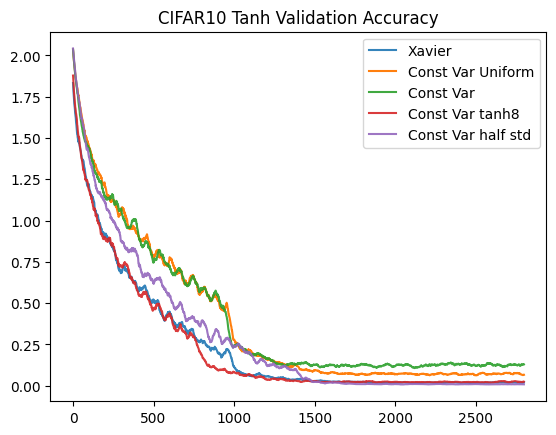

In [16]:
plt.plot(np.array(window_data(xavier_loss_loaded[0])).reshape(-1, 1), label="Xavier", alpha=0.9)
plt.plot(window_data(const_var_loss_uniform_loaded[0]), label="Const Var Uniform")
plt.plot((window_data(const_var_loss_loaded[0])), label="Const Var", alpha=0.9)
plt.plot(np.array(window_data(const_var_loss_tanh8_loaded[0])).reshape(-1, 1), label="Const Var tanh8", alpha=0.9)
plt.plot(np.array(window_data(const_var_loss_half_std_loaded[0])).reshape(-1, 1), label="Const Var half std", alpha=0.9)

plt.title("CIFAR10 Tanh Validation Accuracy")
plt.legend()
plt.savefig("./TanhCIFAR10ValidationAccuracy.png", dpi=360, bbox_inches="tight")

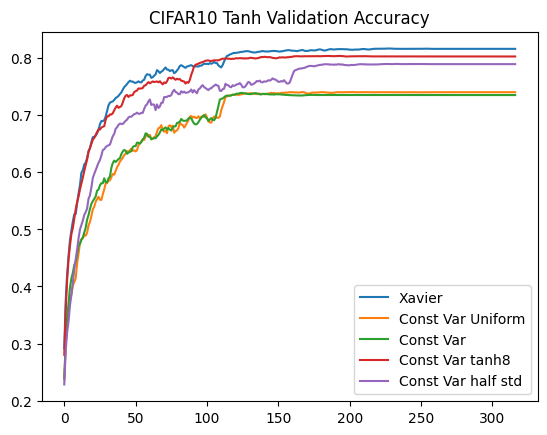

In [18]:
window_size = 4

plt.plot(np.array(window_data(xavier_acc_validation_loaded[0], window_size)).reshape(-1, 1), label="Xavier")
plt.plot(np.array(window_data(const_var_acc_validation_uniform_loaded[0], window_size)), label="Const Var Uniform")
plt.plot(np.array(window_data(const_var_acc_validation_loaded[0], window_size)).reshape(-1, 1), label="Const Var")
plt.plot(np.array(window_data(const_var_acc_validation_tanh8_loaded[0], window_size)).reshape(-1, 1), label="Const Var tanh8")
plt.plot(np.array(window_data(const_var_acc_validation_half_std_loaded[0], window_size)).reshape(-1, 1), label="Const Var half std")

plt.title("CIFAR10 Tanh Validation Accuracy")
plt.legend()
plt.savefig("./TanhCIFAR10ValidationAccuracy.png", dpi=360, bbox_inches="tight")

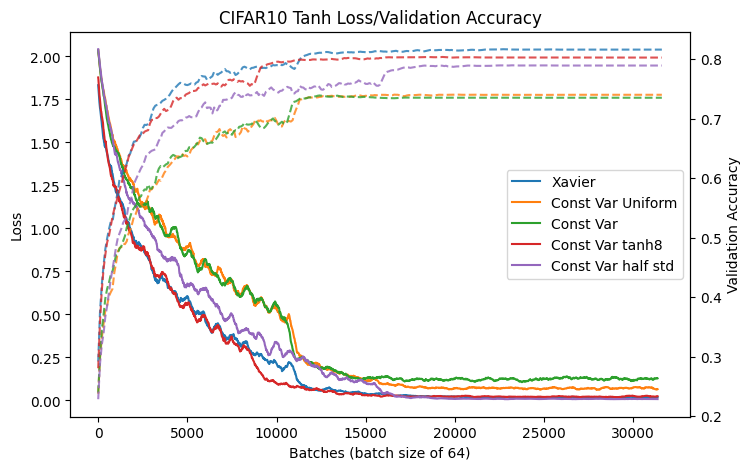

In [22]:

fig, ax = plt.subplots(figsize=(8, 5))

def genX(recorded_every, num_data):
    return [i*recorded_every for i in range(len(num_data))]

loss_recorded_every = 11.2


ax.plot(genX(loss_recorded_every, window_data(xavier_loss_loaded[0])), window_data(xavier_loss_loaded[0]), label="Xavier")
ax.plot(genX(loss_recorded_every, window_data(xavier_loss_loaded[0])), window_data(const_var_loss_uniform_loaded[0]), label="Const Var Uniform")
ax.plot(genX(loss_recorded_every, window_data(xavier_loss_loaded[0])), window_data(const_var_loss_loaded[0]), label="Const Var")
ax.plot(genX(loss_recorded_every, window_data(xavier_loss_loaded[0])), np.array(window_data(const_var_loss_tanh8_loaded[0])), label="Const Var tanh8")
ax.plot(genX(loss_recorded_every, window_data(xavier_loss_loaded[0])), np.array(window_data(const_var_loss_half_std_loaded[0])), label="Const Var half std")

valid_alpha = 0.8

window_size = 4

valid_recorded_every = 100
ax_twinx = ax.twinx()

ax_twinx.plot(genX(valid_recorded_every, window_data(xavier_acc_validation_loaded[0], window_size)), np.array(window_data(xavier_acc_validation_loaded[0], window_size)), label="Xavier", alpha=valid_alpha, linestyle="--")
ax_twinx.plot(genX(valid_recorded_every, window_data(xavier_acc_validation_loaded[0], window_size)), np.array(window_data(const_var_acc_validation_uniform_loaded[0], window_size)), label="Const Var Uniform", alpha=valid_alpha, linestyle="--")
ax_twinx.plot(genX(valid_recorded_every, window_data(xavier_acc_validation_loaded[0], window_size)), np.array(window_data(const_var_acc_validation_loaded[0], window_size)), label="Const Var", alpha=valid_alpha, linestyle="--")
ax_twinx.plot(genX(valid_recorded_every, window_data(xavier_acc_validation_loaded[0], window_size)), np.array(window_data(const_var_acc_validation_tanh8_loaded[0], window_size)), label="Const Var tanh8", alpha=valid_alpha, linestyle="--")
ax_twinx.plot(genX(valid_recorded_every, window_data(xavier_acc_validation_loaded[0], window_size)), np.array(window_data(const_var_acc_validation_half_std_loaded[0], window_size)), label="Const Var half std", alpha=valid_alpha, linestyle="--")

ax.set_title("CIFAR10 Tanh Loss/Validation Accuracy")
ax.set_ylabel("Loss")
ax.set_xlabel("Batches (batch size of 64)")
ax_twinx.set_ylabel("Validation Accuracy")
ax.legend(loc="center right")
plt.savefig("./TanhCIFAR10LossValidationAccuracy.png", dpi=360, bbox_inches="tight")

In [1]:
#########################################################
################## Plot for Paper #######################
#########################################################


In [7]:
import numpy as np

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import matplotlib.pyplot as plt

In [4]:
xavier_loss_loaded = []

const_var_loss_loaded = []
const_var_loss_tanh8_loaded = []
const_var_loss_half_std_loaded = []
const_var_loss_uniform_loaded = []


xavier_acc_validation_loaded = []

const_var_acc_validation_loaded = []
const_var_acc_validation_tanh8_loaded = []
const_var_acc_validation_half_std_loaded = []
const_var_acc_validation_uniform_loaded = []

for i in range(0, 5):

    def loadOpenFile(filename):
        return open("XavierCIFAR_test/" + str(i) + "/" + filename, "r")

    # Load data
    with loadOpenFile("xavier_normal_loss_arr") as f:
        xavier_loss_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("xavier_normal_acc_validation") as f:
        xavier_acc_validation_loaded.append([float(i[1:-1]) for i in f.read().split(",")])

    #######################

    with loadOpenFile("const_var_normal_loss_arr") as f:
        const_var_loss_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("const_var_normal_acc_validation") as f:
        const_var_acc_validation_loaded.append([float(i[1:-1]) for i in f.read().split(",")])

    #######################

    with loadOpenFile("const_var_tanh8_loss_arr") as f:
        const_var_loss_tanh8_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("const_var_tanh8_acc_validation") as f:
        const_var_acc_validation_tanh8_loaded.append([float(i[1:-1]) for i in f.read().split(",")])

    #######################

    with loadOpenFile("const_var_half_std_loss_arr") as f:
        const_var_loss_half_std_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("const_var_half_std_acc_validation") as f:
        const_var_acc_validation_half_std_loaded.append([float(i[1:-1]) for i in f.read().split(",")])

    #######################

    with loadOpenFile("const_var_uniform_loss_arr") as f:
        const_var_loss_uniform_loaded.append([float(i) for i in f.read().split(",")])

    with loadOpenFile("const_var_uniform_acc_validation") as f:
        const_var_acc_validation_uniform_loaded.append([float(i[1:-1]) for i in f.read().split(",")])



In [6]:
def get_mean(data):
    return np.mean(data, axis=0)

def get_std(data):
    return np.std(data, axis=0)

def window_data(data, moving_window_size=160):
    return np.convolve(data, np.ones(moving_window_size), 'valid') / moving_window_size

window_size = 100


5

In [26]:
xavier_loss_mean = get_mean(xavier_loss_loaded)
xavier_loss_std = get_std(xavier_loss_loaded)

const_var_loss_mean = get_mean(const_var_loss_loaded)
const_var_loss_std = get_std(const_var_loss_loaded)

const_var_loss_tanh8_mean = get_mean(const_var_loss_tanh8_loaded)
const_var_loss_tanh8_std = get_std(const_var_loss_tanh8_loaded)

const_var_loss_half_std_mean = get_mean(const_var_loss_half_std_loaded)
const_var_loss_half_std_std = get_std(const_var_loss_half_std_loaded)

const_var_loss_uniform_mean = get_mean(const_var_loss_uniform_loaded)
const_var_loss_uniform_std = get_std(const_var_loss_uniform_loaded)


xavier_acc_mean = get_mean(xavier_acc_validation_loaded)
xavier_acc_std = get_std(xavier_acc_validation_loaded)

const_var_acc_mean = get_mean(const_var_acc_validation_loaded)
const_var_acc_std = get_std(const_var_acc_validation_loaded)

const_var_acc_tanh8_mean = get_mean(const_var_acc_validation_tanh8_loaded)
const_var_acc_tanh8_std = get_std(const_var_acc_validation_tanh8_loaded)

const_var_acc_half_std_mean = get_mean(const_var_acc_validation_half_std_loaded)
const_var_acc_half_std_std = get_std(const_var_acc_validation_half_std_loaded)

const_var_acc_uniform_mean = get_mean(const_var_acc_validation_uniform_loaded)
const_var_acc_uniform_std = get_std(const_var_acc_validation_uniform_loaded)

In [42]:
loss_dict_mean = {
    "xavier": xavier_loss_mean,
    "const_var": const_var_loss_mean,
    "const_var_acc_uniform": const_var_loss_uniform_mean,
    "const_var_half_std": const_var_loss_half_std_mean,
    "const_var_tanh8": const_var_loss_tanh8_mean
}

loss_dict_std = {
    "xavier": xavier_loss_std,
    "const_var": const_var_loss_std,
    "const_var_acc_uniform": const_var_loss_uniform_std,
    "const_var_half_std": const_var_loss_half_std_std,
    "const_var_tanh8": const_var_loss_tanh8_std
}

acc_dict_mean = {
    "xavier": xavier_acc_mean,
    "const_var": const_var_acc_mean,
    "const_var_acc_uniform": const_var_acc_uniform_mean,
    "const_var_half_std": const_var_acc_half_std_mean,
    "const_var_tanh8": const_var_acc_tanh8_mean
}

acc_dict_std = {
    "xavier": xavier_acc_std,
    "const_var": const_var_acc_std,
    "const_var_acc_uniform": const_var_acc_uniform_std,
    "const_var_half_std": const_var_acc_half_std_std,
    "const_var_tanh8": const_var_acc_tanh8_std
}

activation_color_dict = {
    "xavier": "tab:blue",
    "const_var": "tab:orange",
    "const_var_tanh8": "tab:red",
    "const_var_half_std": "tab:green",
    "const_var_acc_uniform": "tab:purple"
}

activation_function_dict_names = {
    "xavier": "Xavier",
    "const_var": "Constant Variance (CVI)",
    "const_var_tanh8": "CVI Tanh8",
    "const_var_half_std": "CVI Half Std.",
    "const_var_acc_uniform": "CVI Uniform"
}

single_col = "tab:purple"

activation_color_dict_const_var = {
    "sigmoid": "tab:orange",
    "tanh": "tab:orange",
    "relu": "tab:orange",
    "softsign": "tab:orange",
    "elu": "tab:orange",
}

activation_color_dict_xavier = {
    "sigmoid": single_col,
    "tanh": single_col,
    "relu": single_col,
    "softsign": single_col,
    "elu": single_col,
}

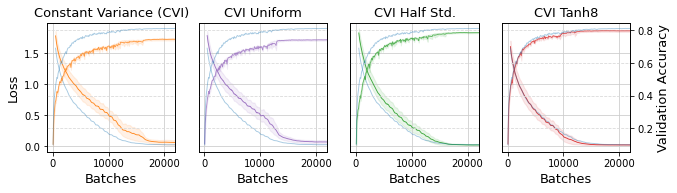

In [44]:
start = 1
stop = 5

include = ['const_var', 'const_var_tanh8', 'const_var_half_std', 'const_var_acc_uniform',]

# Get accuracy every 100
# Get loss every 10

plt.rcParams.update({
    "text.usetex": False,

})

plt.rcParams.update({'font.size': 14})
font_size = 13

plt.rc('font', size=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('axes', titlesize=font_size)

plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)

plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)

fig, ax = plt.subplots(1, stop-start, figsize=(4.8*2, 0.96*1.5*2))
lw=0.9

tick_font_size = 8

window_size = 100
valid_window_size = 4
ax[0].set_ylabel("Loss")

std_alpha = 0.1

##########################################################
####################### LOSS #############################
##########################################################
cur_i = 0
for i, (activation_function, loss) in enumerate(loss_dict_mean.items()):
    if activation_function not in include:
        continue
    i = cur_i

    ax[i].grid(visible=True, which='both', color='0.8', linestyle='-')
    ax[i].set_title(activation_function_dict_names[activation_function])
    ax[i].set_xlabel("Batches")
    ax[i].sharey(ax[0])
    ax[i].set_xlim([-1000, 22_000])
    ax[i].set_xticks([0, 10_000, 20_000])

    if i != 0:
        ax[i].label_outer()
        ax[i].tick_params('y', width=0)

    x_axis = [(window_size/2)*10 + i*100*len(acc_dict_mean["xavier"])/len(loss_dict_mean["xavier"]) for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(loss_dict_std[activation_function], window_size)

    ax[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict[activation_function], alpha=std_alpha)
    ax[i].plot(x_axis, means, label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.9, lw=lw)

    ax[i].plot(x_axis, window_data(loss_dict_mean["xavier"], window_size), color=activation_color_dict["xavier"], linestyle='-', alpha=0.4, lw=lw)

    cur_i += 1


##########################################################
##################### ACCURACY ###########################
##########################################################
valid_alpha = 0.8
ax_valid = [a.twinx() for a in ax]

cur_i = 0
window_size = 1
for i, (activation_function, loss) in enumerate(acc_dict_mean.items()):
    if activation_function not in include:
        continue

    i = cur_i
    ax_valid[stop-start-1].set_ylabel("Validation Accuracy")
    ax_valid[i].sharey(ax_valid[0])

    ax_valid[i].grid(visible=True, which='both', color='0.85', linestyle='--')

    if i + start != stop-1:
        ax_valid[i].label_outer()
        ax_valid[i].tick_params('y', width=0)

    x_axis = [((window_size/2)*100+i*100) for i in range(len(window_data(loss, window_size)))]

    means = window_data(loss, window_size)
    stds = window_data(acc_dict_std[activation_function], window_size)

    ax_valid[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict[activation_function], alpha=std_alpha)
    ax_valid[i].plot(x_axis, means, label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.9*valid_alpha, lw=lw)
    ax_valid[i].plot(x_axis, window_data(acc_dict_mean["xavier"], window_size), color=activation_color_dict["xavier"], linestyle='-', alpha=0.4, lw=lw)
    cur_i += 1


labels = ["Constant Variance", "He"]

red_patch = mpatches.Patch(color='red', label='The red data')
line1 = mlines.Line2D([], [], color='black', label='Constant Variance')
line2 = mlines.Line2D([], [], color='black', label='He', linestyle="--")

fig.tight_layout()
fig.savefig("./CIFAR10_FashionMNIST_xavier_1_hires.png", bbox_inches='tight', dpi=800)
